In [1]:
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

In [2]:
def list_all_runs_for_baseline(level, each_run_dirs, display_match=False):
    dir_regex =f"^BabyAI-{level}-v0_ppo_bow_endpool_res_gru_mem_seed"
    runs = []
    for dir_name in each_run_dirs:
        if re.match(dir_regex, dir_name):
            runs.append(dir_name)
            if display_match:
                print(dir_name)
    print(f"Found {len(runs)} baseline runs for {level}")
    return runs

def list_all_runs_per_lang_train_mode(level, each_run_dirs, lang_train_mode, display_match=False):
    dir_regex =f"^BabyAI-{level}-v0_ppo_HRL-Flamingo_full_all_Lang{lang_train_mode}"
    runs = []
    for dir_name in each_run_dirs:
        if re.match(dir_regex, dir_name):
            runs.append(dir_name)
            if display_match:
                print(dir_name)
    print(f"Found {len(runs)} runs for {level} with lang_train_mode={lang_train_mode}")
    return runs

def load_log(dir_, level):
    """Loads log from a directory and adds it to a list of dataframes."""
    df = pd.read_csv(os.path.join(dir_, 'log.csv'))
    if not len(df):
        print("empty df at {}".format(dir_))
        return
    df['level'] = level
    df['model'] = dir_
    seed_regrex = f"seed\d+"
    df['seed'] = int(re.findall(seed_regrex, dir_, flags=re.IGNORECASE)[0][4:])
    return df

def load_runs_of_all_seeds_for_one_config(level, env_data_dir, list_of_dirs):
    data = []
    for dir_name in list_of_dirs:
        data.append(load_log(os.path.join(env_data_dir, dir_name), level))
    return data

def get_plot_data(list_of_pd_data, sel_cols, sel_cond):
    plot_data = []
    for pd_data in list_of_pd_data:
        plot_data.append(pd_data[sel_cols][sel_cond])
    return plot_data


def create_segments(points, left_extension_x=0.0, right_extention_x=1e6):
    """
    Creates a list of line segments from the input list of 2D points.

    Args:
    points (list): List of 2D points (x, y) as tuples.
    extension (float): The extension value for the first and last line segments.

    Returns:
    list: List of line segments as tuples (point1, point2).
    """
    segments = []
    for i in range(len(points) - 1):
        point1, point2 = points[i], points[i + 1]
        if (i == 0) and (left_extension_x < point1[0]):
            dx = point2[0] - point1[0]
            dy = point2[1] - point1[1]
            left_extension_y = point1[1] - (point1[0]-left_extension_x) * (dy/dx)
            point1 = (left_extension_x, left_extension_y)
        if (i == len(points) - 2) and (right_extention_x > point2[0]):
            dx = point2[0] - point1[0]
            dy = point2[1] - point1[1]
            right_extention_y = point2[1] + (right_extention_x-point2[0]) * (dy/dx)
            point2 = (right_extention_x, right_extention_y)
        segments.append((point1, point2))
    return segments

def sample_from_line(segments, x_values):
    """
    Samples points from the created line segments.

    Args:
    segments (list): List of line segments as tuples (point1, point2).
    x_values (list): List of x values for which the corresponding y values are needed.

    Returns:
    list: List of sampled points (x, y) as tuples.
    """
    sampled_points = []

    for x in x_values:
        for segment in segments:
            point1, point2 = segment
            if point1[0] <= x <= point2[0]:
                t = (x - point1[0]) / (point2[0] - point1[0])
                sampled_y = point1[1] + t * (point2[1] - point1[1])
                sampled_points.append((x, sampled_y))
                break

    return sampled_points

import matplotlib.pyplot as plt

def plot_segments(segments, points=None, sampled_points=None):
    """
    Plots the created line segments.

    Args:
    segments (list): List of line segments as tuples (point1, point2).
    points (list, optional): List of original 2D points (x, y) as tuples.
    sampled_points (list, optional): List of sampled 2D points (x, y) as tuples.
    """

    # Plot line segments
    for segment in segments:
        point1, point2 = segment
        plt.plot([point1[0], point2[0]], [point1[1], point2[1]], 'b-')

    # Plot original points
    if points:
        x, y = zip(*points)
        plt.plot(x, y, 'ro', label='Original Points')

    # Plot sampled points
    if sampled_points:
        x, y = zip(*sampled_points)
        plt.plot(x, y, 'g+', label='Sampled Points')

    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')

    if points or sampled_points:
        plt.legend()

    plt.show()

def find_largest_number_of_points(list_of_lines_of_points):
    """
    Finds the largest number of points in the input list of lines of points.

    Args:
    list_of_lines_of_points (list): List of lines of points.

    Returns:
    int: The largest number of points in the input list of lines of points.
    """
    largest_number_of_points = 0
    for line_of_points in list_of_lines_of_points:
        if len(line_of_points) > largest_number_of_points:
            largest_number_of_points = len(line_of_points)
    return largest_number_of_points

def stat_number_of_points(list_num_of_points):
    """
    return the max, min, mean (floor(mean)), std of the number of points in the input list of lines of points.

    Args:
    list_num_of_points (list): List of the number of points of lines.

    Returns:
    (max, min, mean, std)
    """
    max_n, min_n, mean_n, std_n = 0, 0, 0, 0.0
    max_n = max(list_num_of_points)
    min_n = min(list_num_of_points)
    mean_n = int(np.mean(list_num_of_points))
    std_n = np.std(list_num_of_points)
    return (max_n, min_n, mean_n, std_n)

def decide_num_points_to_sample(list_num_of_points, given_num_samples, config, debug=False):
    lang_comp_mode=config["lang_comp_mode"]
    lr=config["lr"]
    max_n_nodes, min_n_nodes, mean_n_nodes, std_n_nodes = stat_number_of_points(list_num_of_points)

    num_samples = 0
    if given_num_samples == "max":
        num_samples = max_n_nodes
    elif given_num_samples == "mean":
        num_samples = mean_n_nodes
    elif given_num_samples == "min":
        num_samples = min_n_nodes
    else: # assume given_num_samples is an integer in this case
        num_samples = given_num_samples
    if debug:
        print(f"[{lang_comp_mode}, LR({lr})] max_n_nodes: {max_n_nodes}, min_n_nodes: {min_n_nodes}, mean_n_nodes: {mean_n_nodes}, std_n_nodes: {std_n_nodes}, num_samples: {num_samples}")

    return num_samples

def plot_perf_per_lang_mode_per_level(
        level,
        lang_comp_mode,
        short_lr_list,
        line_colors,
        line_styles,
        df_3lr_3lang,
        df_paper_levels,
        fig_dir,
        gh = None,
        debug=False,
        num_samples = None,
        fig_format='svg'
):
    num_seeds=3
    min_x=0.0
    max_x=1e6
    gh = None
    df_3lr_1lang = df_3lr_3lang[lang_comp_mode]
    line_style = line_styles[lang_comp_mode]
    given_num_samples = num_samples

    plt.figure()

    for key, lr in short_lr_list.items():
        # Load data
        segments_3seeds = []
        list_num_of_points = []
        for i in range(num_seeds):
            frames_rewards_i = list(zip(df_3lr_1lang[lr][i]['frames'],df_3lr_1lang[lr][i]['return_mean']))
            points = sorted(frames_rewards_i, key=lambda x: x[0])
            list_num_of_points.append(len(points))
            if debug:
                seed = df_3lr_1lang[lr][i]['seed'].unique()[0]
                print(f"[{lang_comp_mode}, LR({lr}), Run {i}] left: {points[0]}, right: {points[-1]}, num_points: {len(points)}, seed:{seed}")

            segments_i = create_segments(points, left_extension_x=min_x, right_extention_x=max_x)
            segments_3seeds.append(segments_i)
            if debug:
                print(f"[{lang_comp_mode}, LR({lr}), Extend] left: {segments_i[0][0]}, right: {segments_i[-1][1]}, num_points: {len(segments_i)+1}")

        config = {"lang_comp_mode":lang_comp_mode, "lr":lr}
        num_samples = decide_num_points_to_sample(list_num_of_points, given_num_samples, config, debug=debug)

        # Draw samples from segment lines and plot
        line_color = line_colors[lr]
        x_values = np.linspace(min_x, max_x, num_samples)

        df_3seeds = []
        for segments, i in zip(segments_3seeds, range(num_seeds)):
            sampled_points = sample_from_line(segments, x_values)
            df = pd.DataFrame(sampled_points, columns=['frames', 'return_mean'])
            df_3seeds.append(df)
        df_3seeds = pd.concat(df_3seeds, axis=0)

        if gh is None:
            gh = sns.lineplot(x='frames', y='return_mean', data=df_3seeds, errorbar='se', err_style='band', label=f"{lang_comp_mode}_lr{lr}_3Seeds", color=line_color, linestyle=line_style)
        else:
            sns.lineplot(x='frames', y='return_mean', data=df_3seeds, errorbar='se', err_style='band', label=f"{lang_comp_mode}_lr{lr}_3Seeds", color=line_color, linestyle=line_style, ax=gh)

    baseline_data = df_paper_levels[df_paper_levels['level']==level]
    baseline_data = baseline_data[baseline_data['frames']<=max_x]
    sns.lineplot(x='frames', y='return_mean', data=baseline_data, errorbar='se', err_style='band', color="blue",  label='Baseline_3Seeds', ax=gh)

    gh.set(xlabel='Frames', ylabel='Average Return')
    fn = f"Img_{level}_{lang_comp_mode}_3lr_perf.{fig_format}"
    fig_fp = os.path.join(fig_dir, fn)
    gh.figure.savefig(fig_fp, dpi=600, format=fig_format)
    plt.show()
    plt.close(gh.figure)

def plot_best_perf_every_lang_mode_per_level(
        level,
        lang_comp_mode_and_lr_pairs,
        line_colors,
        line_styles,
        df_3lr_3lang,
        df_paper_levels,
        fig_dir,
        gh = None,
        debug=False,
        num_samples=None,
        fig_format='svg'
):
    num_seeds=3
    min_x=0.0
    max_x=1e6
    gh = None
    given_num_samples = num_samples

    plt.figure()


    for lang_comp_mode, lr in lang_comp_mode_and_lr_pairs.items():
        df_3seeds = df_3lr_3lang[lang_comp_mode][lr]
        segments_3seeds = []
        list_num_of_points = []

        # Load data
        for i in range(num_seeds):
            frames_rewards_i = list(zip(df_3seeds[i]['frames'], df_3seeds[i]['return_mean']))
            points = sorted(frames_rewards_i, key=lambda x: x[0])
            list_num_of_points.append(len(points))
            if debug:
                seed = df_3seeds[i]['seed'].unique()[0]
                print(f"[{lang_comp_mode}, LR({lr}), Run {i}] left: {points[0]}, right: {points[-1]}, num_points: {len(points)}, seed:{seed}")

            segments_i = create_segments(points, left_extension_x=min_x, right_extention_x=max_x)
            segments_3seeds.append(segments_i)
            if debug:
                print(f"[{lang_comp_mode}, LR({lr}), Extend] left: {segments_i[0][0]}, right: {segments_i[-1][1]}, num_points: {len(segments_i)+1}")

        config = {"lang_comp_mode":lang_comp_mode, "lr":lr}
        num_samples = decide_num_points_to_sample(list_num_of_points, given_num_samples, config, debug=debug)

        # Draw samples from segment lines and plot
        line_color = line_colors[lr]
        line_style = line_styles[lang_comp_mode]

        x_values = np.linspace(min_x, max_x, num_samples)

        df_3seeds = []
        for segments, i in zip(segments_3seeds, range(num_seeds)):
            sampled_points = sample_from_line(segments, x_values)
            df = pd.DataFrame(sampled_points, columns=['frames', 'return_mean'])
            df_3seeds.append(df)
        df_3seeds = pd.concat(df_3seeds, axis=0)

        if gh is None:
            gh = sns.lineplot(x='frames', y='return_mean', data=df_3seeds, errorbar='se', err_style='band', label=f"{lang_comp_mode}_lr{lr}_3Seeds", color=line_color, linestyle=line_style)
        else:
            sns.lineplot(x='frames', y='return_mean', data=df_3seeds, errorbar='se', err_style='band', label=f"{lang_comp_mode}_lr{lr}_3Seeds", color=line_color, linestyle=line_style, ax=gh)

    baseline_data = df_paper_levels[df_paper_levels['level']==level]
    baseline_data = baseline_data[baseline_data['frames']<=max_x]
    sns.lineplot(x='frames', y='return_mean', data=baseline_data, errorbar='se', err_style='band', color="blue",  label='Baseline_3Seeds', ax=gh)

    gh.set(xlabel='Frames', ylabel='Average Return')
    fn = f"Img_best_perf_per_lang_mode_for_{level}.{fig_format}"
    fig_fp = os.path.join(fig_dir, fn)
    gh.figure.savefig(fig_fp, dpi=600, format=fig_format)
    plt.show()
    plt.close(gh.figure)


def load_result_per_level(
        exp_result_dir,
        level,
        lr_list,
        short_lr_list,
        lang_comp_modes,
        history_type='full',
        debug=False
        ):

    level_exp_result_dir= os.path.join(exp_result_dir, level)
    each_run_dirs = os.listdir(level_exp_result_dir)
    print(f"total runs: {len(each_run_dirs)}")

    df_3lr_3lang = {}
    loaded_runs = 0
    for lang_comp_mode in lang_comp_modes:
        df_3lr_3lang[lang_comp_mode] = {}
        for lr in lr_list:
            short_lr_name = short_lr_list[lr]
            df_3lr_3lang[lang_comp_mode][short_lr_name] = []

    if debug:
        num_orig_data_points = {}
        ave_num_data_points = {}
        std_num_data_points = {}
        for lang_comp_mode in lang_comp_modes:
            num_orig_data_points[lang_comp_mode] = {}
            ave_num_data_points[lang_comp_mode] = {}
            std_num_data_points[lang_comp_mode] = {}
            for lr in lr_list:
                short_lr_name = short_lr_list[lr]
                num_orig_data_points[lang_comp_mode][short_lr_name] = []
                ave_num_data_points[lang_comp_mode][short_lr_name] = 0.0
                std_num_data_points[lang_comp_mode][short_lr_name] = 0.0

    for run_dir in each_run_dirs:
        for lang_comp_mode in lang_comp_modes:
            for lr in lr_list:
                filename_regex = f"^BabyAI-{level}-v0_ppo_HRL-Flamingo_{history_type}_all_Lang{lang_comp_mode}_noPrior_lr{lr}sfixed"
                if re.match(filename_regex, run_dir):
                    df = load_log(os.path.join(level_exp_result_dir, run_dir), level)
                    short_lr_name = short_lr_list[lr]
                    df['lr'] = short_lr_name
                    df['lang_mode'] = lang_comp_mode
                    df_3lr_3lang[lang_comp_mode][short_lr_name].append(df)
                    loaded_runs += 1
                    if debug:
                        num_orig_data_points[lang_comp_mode][short_lr_name].append(df.shape[0])
                        print(f"[Run {loaded_runs}, {lang_comp_mode}, lr{short_lr_name}] {df.shape[0]} data points")
    print(f"loaded runs: {loaded_runs}")
    if debug:
        print(f"{level}", end="")
        for lang_comp_mode in lang_comp_modes:
            print(f"\t{lang_comp_mode}", end="")
        print("")
        for lr in lr_list:
            short_lr_name = short_lr_list[lr]
            print(f"lr{short_lr_name}", end="")
            for lang_comp_mode in lang_comp_modes:
                print(f"\t{num_orig_data_points[lang_comp_mode][short_lr_name]}", end="")
                ave_num_data_points[lang_comp_mode][short_lr_name] = np.mean(num_orig_data_points[lang_comp_mode][short_lr_name])
                std_num_data_points[lang_comp_mode][short_lr_name] = np.std(num_orig_data_points[lang_comp_mode][short_lr_name])
            print("")
        print("average of number of data points")
        print(ave_num_data_points)
        print("std of number of data points")
        print(std_num_data_points)
    return df_3lr_3lang

def plot_line_segments_example(
        level,
        lang_comp_mode,
        lr,
        df_3lr_3lang,
        df_paper_levels,
        fig_dir,
        debug=False,
        num_samples=None,
        fig_format='svg',
):
    given_num_samples = num_samples

    df_3seeds = df_3lr_3lang[lang_comp_mode][lr]
    seeds = [df_3seeds[i]['seed'].unique()[0] for i in range(3)]
    # Original Experiment Results of 3 Seeds
    g_ri = sns.lineplot(x='frames', y='return_mean', data=df_3seeds[0], label=f"{lang_comp_mode}_lr{lr}_Seed{seeds[0]}",color='purple')
    sns.lineplot(x='frames', y='return_mean', data=df_3seeds[1], label=f"{lang_comp_mode}_lr{lr}_Seed{seeds[1]}", color='red', ax=g_ri)
    sns.lineplot(x='frames', y='return_mean', data=df_3seeds[2], label=f"{lang_comp_mode}_lr{lr}_Seed{seeds[2]}", color='green', ax=g_ri)

    # Merged Result of 3 Seeds Using line segments
    segments_3seeds = []
    list_num_of_points = []
    min_x=0
    max_x=1e6
    num_seeds = 3
    for i in range(num_seeds):
        frames_rewards_i = list(zip(df_3seeds[i]['frames'],df_3seeds[i]['return_mean']))
        points = sorted(frames_rewards_i, key=lambda x: x[0])
        list_num_of_points.append(len(points))
        if debug:
            print(f"[{lang_comp_mode}, LR({lr}), SEED {seeds[i]}] left: {points[0]}, right: {points[-1]}, num_points: {len(points)}")
        segments_i = create_segments(points, left_extension_x=min_x, right_extention_x=max_x)
        segments_3seeds.append(segments_i)
        if debug:
            print(f"[{lang_comp_mode}, LR({lr}), Extend] left: {segments_i[0][0]}, right: {segments_i[-1][1]}, num_points: {len(segments_i)+1}")

    config = {"lang_comp_mode":lang_comp_mode, "lr":lr}
    num_samples = decide_num_points_to_sample(list_num_of_points, given_num_samples, config, debug=debug)

    # Draw samples from segment lines and plot them
    x_values = np.linspace(min_x, max_x, num_samples)

    df_3seeds = []
    for segments in segments_3seeds:
        sampled_points = sample_from_line(segments, x_values)
        df = pd.DataFrame(sampled_points, columns=['frames', 'return_mean'])
        df_3seeds.append(df)
    df_3seeds = pd.concat(df_3seeds, axis=0)
    sns.lineplot(x='frames', y='return_mean', data=df_3seeds, errorbar='se', err_style='band', label=f"{lang_comp_mode}_lr{lr}_3Seeds", color='blue', ax=g_ri)

    baseline_data = df_paper_levels[df_paper_levels['level']==level]
    baseline_data = baseline_data[baseline_data['frames']<=max_x]
    sns.lineplot(x='frames', y='return_mean', data=baseline_data, errorbar='se', err_style='band', color="black",  label='Baseline_3Seeds', ax=g_ri)

    g_ri.set(xlabel='Frames', ylabel='Average Return')
    fn = f"Img_ave_perf_repr_using_line_segments_{level}_{lang_comp_mode}_lr{lr}.{fig_format}"
    fig_fp = os.path.join(fig_dir, fn)
    g_ri.figure.savefig(fig_fp,dpi=600, format=fig_format)


# Abstract History vs Full History on Best LR per Language Mode per env

def plot_selected_config(all_results, selected_configs, history_type, line_colors, line_styles, min_x, max_x, num_samples=None, gh=None, abs_marker='x', debug=False):
    num_seeds=3

    marker = None if history_type=="Full" else abs_marker
    given_num_samples = num_samples

    plt.figure()

    for lang_comp_mode, lr in selected_configs.items():
        df_3seeds = all_results[lang_comp_mode][lr]
        list_num_of_points = []
        segment_lines = []

        for i in range(3):
            frames_rewards_i = list(zip(df_3seeds[i]['frames'], df_3seeds[i]['return_mean']))
            points = sorted(frames_rewards_i, key=lambda x: x[0])
            list_num_of_points.append(len(points))
            if debug:
                seed = df_3seeds[i]['seed'].unique()[0]
                print(f"[{lang_comp_mode}, LR({lr}), Run {i}] left: {points[0]}, right: {points[-1]}, num_points: {len(points)}, seed:{seed}")

            segments_i = create_segments(points, left_extension_x=min_x, right_extention_x=max_x)
            segment_lines.append(segments_i)
            if debug:
                print(f"[{lang_comp_mode}, LR({lr}, Extend)] left: {segments_i[0][0]}, right: {segments_i[-1][1]}, num_points: {len(segments_i)+1}")

        config = {"lang_comp_mode":lang_comp_mode, "lr":lr}
        num_samples = decide_num_points_to_sample(list_num_of_points, given_num_samples, config, debug=debug)
        x_values = np.linspace(min_x, max_x, num_samples)

        line_color = line_colors[lr]
        line_style = line_styles[lang_comp_mode]

        df_3seeds = []
        for segments, i in zip(segment_lines, range(num_seeds)):
            sampled_points = sample_from_line(segments, x_values)
            df = pd.DataFrame(sampled_points, columns=['frames', 'return_mean'])
            df_3seeds.append(df)
        df_3seeds = pd.concat(df_3seeds, axis=0)

        if gh is None:
            gh = sns.lineplot(x='frames', y='return_mean', data=df_3seeds, errorbar='se', err_style='band', label=f"{history_type}History_{lang_comp_mode}_lr{lr}", color=line_color, linestyle=line_style, marker=marker)
        else:
            sns.lineplot(x='frames', y='return_mean', data=df_3seeds, errorbar='se', err_style='band', label=f"{history_type}History_{lang_comp_mode}_lr{lr}", color=line_color, linestyle=line_style, marker=marker, ax=gh)

    return gh

def plot_full_vs_abs_selected_lang_mode_per_level(
        level,
        selected_configs,
        abs_line_colors,
        line_colors,
        line_styles,
        df_paper_levels,
        df_full,
        df_abs,
        fig_dir,
        gh = None,
        debug=False,
        num_samples=None,
        abs_marker='x',
        fig_format='svg'
):
    min_x=0.0
    max_x=1e6
    gh = None

    plt.figure()
    history_type="Full"
    gh = None
    gh = plot_selected_config(df_full, selected_configs, history_type, line_colors, line_styles, min_x, max_x, num_samples, gh, abs_marker, debug)
    history_type="Abs"
    gh = plot_selected_config(df_abs, selected_configs, history_type, abs_line_colors, line_styles, min_x, max_x, num_samples, gh, abs_marker,debug)

    baseline_data = df_paper_levels[df_paper_levels['level']==level]
    baseline_data = baseline_data[baseline_data['frames']<=max_x]
    sns.lineplot(x='frames', y='return_mean', data=baseline_data, errorbar='se', err_style='band', color="blue",  label='Baseline', ax=gh)

    gh.set(xlabel='Frames', ylabel='Average Return')
    fn = f"Img_full_vs_abs_{level}.{fig_format}"
    fig_fp = os.path.join(fig_dir, fn)
    gh.figure.savefig(fig_fp, dpi=600, format=fig_format)
    plt.show()
    plt.close(gh.figure)


def load_abs_result_per_level(
        exp_result_dir,
        level,
        selected_lr_list,
        lang_comp_mode_and_lr_pairs,
        history_type='absR0',
        ):

    level_exp_result_dir= os.path.join(exp_result_dir, level)
    each_run_dirs = os.listdir(level_exp_result_dir)
    print(f"total runs: {len(each_run_dirs)}")

    dfs = {}
    loaded_runs = 0
    for lang_comp_mode, short_lr_name in lang_comp_mode_and_lr_pairs.items():
        dfs[lang_comp_mode] = {}
        dfs[lang_comp_mode][short_lr_name] = []

    for (lang_comp_mode, short_lr_name), lr in zip(lang_comp_mode_and_lr_pairs.items(), selected_lr_list):
        filename_regex = f"^BabyAI-{level}-v0_ppo_HRL-Flamingo_{history_type}_all_Lang{lang_comp_mode}_noPrior_lr{lr}sfixed"
        for run_dir in each_run_dirs:
            if re.match(filename_regex, run_dir):
                df = load_log(os.path.join(level_exp_result_dir, run_dir), level)
                df['lr'] = short_lr_name
                df['lang_mode'] = lang_comp_mode
                dfs[lang_comp_mode][short_lr_name].append(df)
                loaded_runs += 1

    print(f"loaded runs: {loaded_runs}")
    return dfs

Number of Segments: 3
Number of Sampled Points: 20


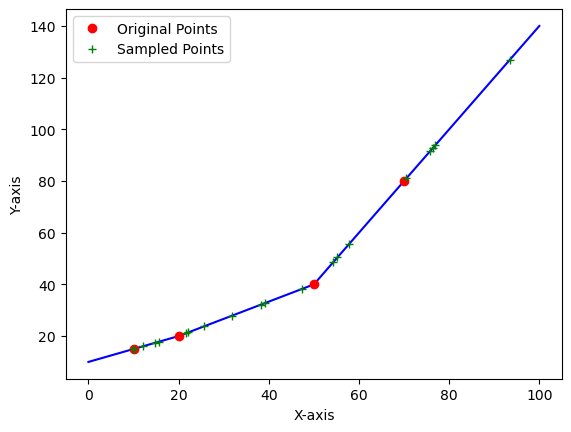

In [3]:
# test segment line and sampling
points = [(10, 15), (20, 20), (50, 40), (70, 80)]
min_x=0.0
max_x=100.0
segments = create_segments(points, left_extension_x=min_x, right_extention_x=max_x)
num_samples = 20
x_values = np.random.uniform(min_x, max_x, num_samples)
x_values.sort()
sampled_points = sample_from_line(segments, x_values)
print(f"Number of Segments: {len(segments)}")
print(f"Number of Sampled Points: {len(sampled_points)}")
plot_segments(segments, points, sampled_points)

In [4]:
fig_dir="/home/jsu/Downloads/cgsul_data/cgsul_images/"
fig_format='svg' # 'svg', 'pdf, 'eps'
num_samples='min' # None, 1000
debug=True
#abs_line_colors = {"1e-4":"deepskyblue", "3e-5":"gold", "1e-5":"coral"}
abs_line_colors = {"1e-4":"mediumslateblue", "3e-5":"mediumseagreen", "1e-5":"coral"}

18
Found 3 baseline runs for GoToLocalR2
Found 3 baseline runs for PickupLocalR2
Found 3 baseline runs for DropNextToLocalR2
Found 3 baseline runs for OpenBoxLocalR2
Found 3 baseline runs for OpenDoorLocalR2
Found 3 baseline runs for PassDoorLocalR2
GoToLocalR2 3
PickupLocalR2 3
DropNextToLocalR2 3
OpenBoxLocalR2 3
OpenDoorLocalR2 3
PassDoorLocalR2 3


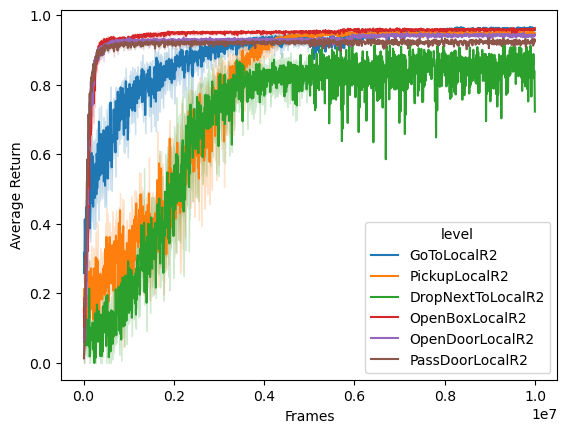

In [5]:
# skill library
data_dir = "/home/jsu/Downloads/cgsul_data/rl_BabyAI/TwoRooms/basic_levels"
basic_level_each_run_dirs = os.listdir(data_dir)
print(len(basic_level_each_run_dirs))
list_of_basic_levels = ["GoToLocalR2", "PickupLocalR2", "DropNextToLocalR2", "OpenBoxLocalR2", "OpenDoorLocalR2", "PassDoorLocalR2"]
basic_level_data = {}
for level in list_of_basic_levels:
    selected_run_dirs = list_all_runs_for_baseline(level, basic_level_each_run_dirs, display_match=False)
    basic_level_data[level] = load_runs_of_all_seeds_for_one_config(level, data_dir, selected_run_dirs)

df_basic_levels = []
for level, runs in basic_level_data.items():
    print(level, len(basic_level_data[level]))
    df_basic_levels.extend(runs)
df_basic_levels = pd.concat(df_basic_levels, axis=0) # concat along rows
g = sns.lineplot(x='frames', y='return_mean', data=df_basic_levels, errorbar='se', err_style='band', hue='level')
g.set(xlabel='Frames', ylabel='Average Return')
fn = f"Img_basic_levels_skill_perf.{fig_format}"
fig_fp = os.path.join(fig_dir, fn)
g.figure.savefig(fig_fp, dpi=600, format=fig_format)

21
Found 3 baseline runs for DiscoverHiddenBallBlueBoxR2
Found 3 baseline runs for GoToBallNeighborOpenRoomR2
Found 3 baseline runs for MoveToNeighborClosedRoomR2
DiscoverHiddenBallBlueBoxR2 3
GoToBallNeighborOpenRoomR2 3
MoveToNeighborClosedRoomR2 3


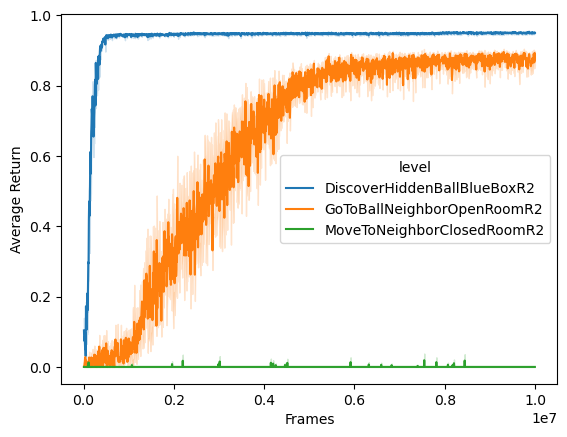

In [6]:
data_dir="/home/jsu/Downloads/cgsul_data/rl_BabyAI/TwoRooms/paper_levels_10M"
paper_level_each_run_dirs = os.listdir(data_dir)
print(len(paper_level_each_run_dirs))
list_of_paper_levels = ["DiscoverHiddenBallBlueBoxR2", "GoToBallNeighborOpenRoomR2", "MoveToNeighborClosedRoomR2"]
paper_level_data = {}
for level in list_of_paper_levels:
    selected_run_dirs = list_all_runs_for_baseline(level, paper_level_each_run_dirs, display_match=False)
    paper_level_data[level] = load_runs_of_all_seeds_for_one_config(level, data_dir, selected_run_dirs)

df_paper_levels = []
for level, runs in paper_level_data.items():
    print(level, len(paper_level_data[level]))
    df_paper_levels.extend(runs)
df_paper_levels = pd.concat(df_paper_levels, axis=0) # concat along rows
gp = sns.lineplot(x='frames', y='return_mean', data=df_paper_levels, errorbar='se', err_style='band', hue='level')
gp.set(xlabel='Frames', ylabel='Average Return')
fn = f"Img_test_levels_baseline_perf.{fig_format}"
fig_fp = os.path.join(fig_dir, fn)
gp.figure.savefig(fig_fp, dpi=600, format=fig_format)

In [7]:
# Plots For Proposed Agent
fig_dir="/home/jsu/Downloads/cgsul_images/"
## Load Experiment Results
exp_result_dir = "/home/jsu/Downloads/cgsul_data/hrl_vlm/TwoRooms/paper_levels"
level = "DiscoverHiddenBallBlueBoxR2"
lr_list = ["0.0001", "3e-05", "1e-05"]
short_lr_list = {"0.0001":"1e-4", "3e-05":"3e-5", "1e-05":"1e-5"}
lang_comp_modes = ["RandomInit", "TuneAll", "FrozenAll"]
history_type = 'full'

df_3lr_3lang_Disc = load_result_per_level(
        exp_result_dir,
        level,
        lr_list,
        short_lr_list,
        lang_comp_modes,
        history_type='full',
        debug=debug
        )

total runs: 43
[Run 1, FrozenAll, lr1e-4] 43 data points
[Run 2, TuneAll, lr3e-5] 143 data points
[Run 3, RandomInit, lr3e-5] 340 data points
[Run 4, TuneAll, lr3e-5] 160 data points
[Run 5, FrozenAll, lr1e-4] 43 data points
[Run 6, RandomInit, lr1e-4] 401 data points
[Run 7, TuneAll, lr1e-4] 213 data points
[Run 8, TuneAll, lr1e-5] 213 data points
[Run 9, FrozenAll, lr3e-5] 103 data points
[Run 10, RandomInit, lr1e-5] 148 data points
[Run 11, TuneAll, lr1e-5] 254 data points
[Run 12, FrozenAll, lr3e-5] 93 data points
[Run 13, RandomInit, lr1e-4] 402 data points
[Run 14, RandomInit, lr3e-5] 397 data points
[Run 15, RandomInit, lr3e-5] 313 data points
[Run 16, FrozenAll, lr1e-4] 45 data points
[Run 17, RandomInit, lr1e-5] 235 data points
[Run 18, FrozenAll, lr1e-5] 144 data points
[Run 19, TuneAll, lr1e-5] 203 data points
[Run 20, FrozenAll, lr1e-5] 153 data points
[Run 21, TuneAll, lr1e-4] 101 data points
[Run 22, TuneAll, lr3e-5] 187 data points
[Run 23, RandomInit, lr1e-4] 406 data p

[RandomInit, LR(1e-4), SEED 3805] left: (17951, 0.6569091796875), right: (999055, 0.9483642578125), num_points: 401
[RandomInit, LR(1e-4), Extend] left: (0, 0.622678721425357), right: (1000000.0, 0.9492733716547176), num_points: 401
[RandomInit, LR(1e-4), SEED 9600] left: (15067, 0.7518798828125), right: (998267, 0.946826171875), num_points: 402
[RandomInit, LR(1e-4), Extend] left: (0, 0.6580863071152887), right: (1000000.0, 0.943844810243584), num_points: 402
[RandomInit, LR(1e-4), SEED 6843] left: (15145, 0.7208984375), right: (998079, 0.9490234375), num_points: 406
[RandomInit, LR(1e-4), Extend] left: (0, 0.49749109588076446), right: (1000000.0, 0.9490234375), num_points: 406
[RandomInit, LR(1e-4)] max_n_nodes: 406, min_n_nodes: 401, mean_n_nodes: 403, std_n_nodes: 2.160246899469287, num_samples: 401


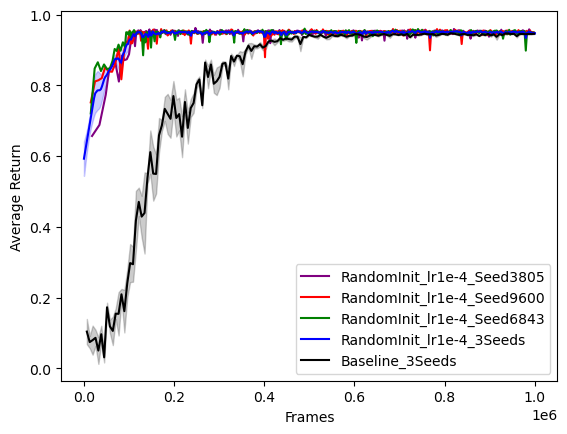

In [8]:
## Show an example of using merged lines of segments to represent the merged performance 
level="DiscoverHiddenBallBlueBoxR2"
lang_comp_mode="RandomInit"
lr="1e-4"
plot_line_segments_example(
        level,
        lang_comp_mode,
        lr,
        df_3lr_3lang_Disc,
        df_paper_levels,
        fig_dir,
        num_samples=num_samples,
        debug=debug
)

Ploting training performance for RandomInit mode and level DiscoverHiddenBallBlueBoxR2
[RandomInit, LR(1e-4), Run 0] left: (17951, 0.6569091796875), right: (999055, 0.9483642578125), num_points: 401, seed:3805
[RandomInit, LR(1e-4), Extend] left: (0.0, 0.622678721425357), right: (1000000.0, 0.9492733716547176), num_points: 401
[RandomInit, LR(1e-4), Run 1] left: (15067, 0.7518798828125), right: (998267, 0.946826171875), num_points: 402, seed:9600
[RandomInit, LR(1e-4), Extend] left: (0.0, 0.6580863071152887), right: (1000000.0, 0.943844810243584), num_points: 402
[RandomInit, LR(1e-4), Run 2] left: (15145, 0.7208984375), right: (998079, 0.9490234375), num_points: 406, seed:6843
[RandomInit, LR(1e-4), Extend] left: (0.0, 0.49749109588076446), right: (1000000.0, 0.9490234375), num_points: 406
[RandomInit, LR(1e-4)] max_n_nodes: 406, min_n_nodes: 401, mean_n_nodes: 403, std_n_nodes: 2.160246899469287, num_samples: 401
[RandomInit, LR(3e-5), Run 0] left: (13829, 0.756494140625), right: (99

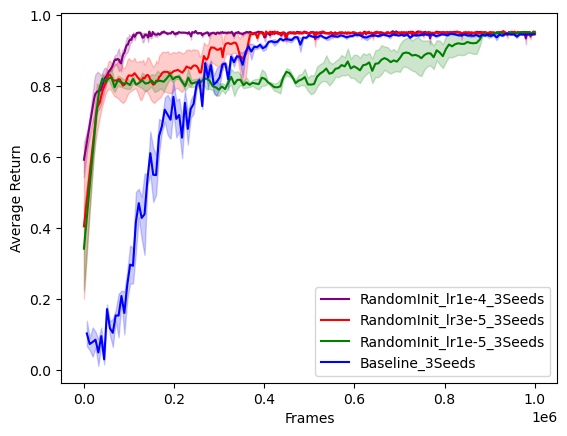

Ploting training performance for TuneAll mode and level DiscoverHiddenBallBlueBoxR2
[TuneAll, LR(1e-4), Run 0] left: (21563, 0.7360595703124999), right: (991706, 0.0405517578125), num_points: 213, seed:7457
[TuneAll, LR(1e-4), Extend] left: (0.0, 0.5908120156918122), right: (1000000.0, 0.03981795185989004), num_points: 213
[TuneAll, LR(1e-4), Run 1] left: (19359, 0.5560791015625), right: (972041, 0.0756591796875), num_points: 101, seed:9277
[TuneAll, LR(1e-4), Extend] left: (0.0, 0.24271676281802262), right: (1000000.0, 0.12240408687712054), num_points: 101
[TuneAll, LR(1e-4), Run 2] left: (16695, 0.78291015625), right: (983944, 0.3440673828124999), num_points: 244, seed:6326
[TuneAll, LR(1e-4), Extend] left: (0.0, 0.7178027913246388), right: (1000000.0, 0.3611684420063789), num_points: 244
[TuneAll, LR(1e-4)] max_n_nodes: 244, min_n_nodes: 101, mean_n_nodes: 186, std_n_nodes: 61.4220373047546, num_samples: 101
[TuneAll, LR(3e-5), Run 0] left: (17528, 0.5918212890625), right: (979560, 

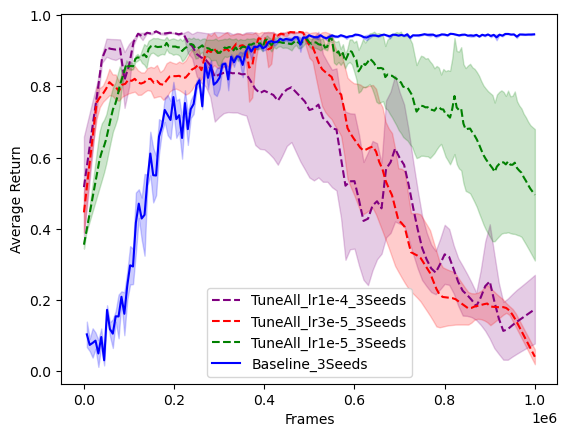

Ploting training performance for FrozenAll mode and level DiscoverHiddenBallBlueBoxR2
[FrozenAll, LR(1e-4), Run 0] left: (16493, 0.6895263671875), right: (992118, 0.0055419921875), num_points: 43, seed:6324
[FrozenAll, LR(1e-4), Extend] left: (0.0, 0.6263162399965339), right: (1000000.0, 0.004979754832436674), num_points: 43
[FrozenAll, LR(1e-4), Run 1] left: (18775, 0.745556640625), right: (999080, 0.0767822265625), num_points: 43, seed:3125
[FrozenAll, LR(1e-4), Extend] left: (0.0, 0.7836275728041944), right: (1000000.0, 0.07615401295826878), num_points: 43
[FrozenAll, LR(1e-4), Run 2] left: (18207, 0.6409912109375), right: (976485, 0.0606445312499999), num_points: 45, seed:2716
[FrozenAll, LR(1e-4), Extend] left: (0.0, 0.5781801624124022), right: (1000000.0, 0.06065874367460962), num_points: 45
[FrozenAll, LR(1e-4)] max_n_nodes: 45, min_n_nodes: 43, mean_n_nodes: 43, std_n_nodes: 0.9428090415820634, num_samples: 43
[FrozenAll, LR(3e-5), Run 0] left: (19523, 0.5640380859375), right: 

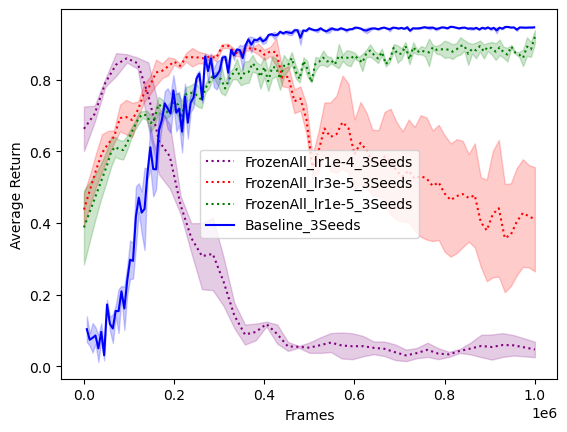

In [9]:
# Initialiation
line_styles = {"RandomInit":"solid", "TuneAll":"dashed", "FrozenAll":"dotted"}
line_colors = {"1e-4":"purple", "3e-5":"red", "1e-5":"green"}
num_samples = 'min' # 'max', 'min', 'mean', 200
for lang_comp_mode in lang_comp_modes:
        print(f"Ploting training performance for {lang_comp_mode} mode and level {level}")
        gh=None
        plot_perf_per_lang_mode_per_level(
                level,
                lang_comp_mode,
                short_lr_list,
                line_colors,
                line_styles,
                df_3lr_3lang_Disc,
                df_paper_levels,
                fig_dir,
                gh,
                num_samples=num_samples,
                debug=debug
        )

Ploting performances of the best lr of each language mode for  level DiscoverHiddenBallBlueBoxR2
[RandomInit, LR(1e-4), Run 0] left: (17951, 0.6569091796875), right: (999055, 0.9483642578125), num_points: 401, seed:3805
[RandomInit, LR(1e-4), Extend] left: (0.0, 0.622678721425357), right: (1000000.0, 0.9492733716547176), num_points: 401
[RandomInit, LR(1e-4), Run 1] left: (15067, 0.7518798828125), right: (998267, 0.946826171875), num_points: 402, seed:9600
[RandomInit, LR(1e-4), Extend] left: (0.0, 0.6580863071152887), right: (1000000.0, 0.943844810243584), num_points: 402
[RandomInit, LR(1e-4), Run 2] left: (15145, 0.7208984375), right: (998079, 0.9490234375), num_points: 406, seed:6843
[RandomInit, LR(1e-4), Extend] left: (0.0, 0.49749109588076446), right: (1000000.0, 0.9490234375), num_points: 406
[RandomInit, LR(1e-4)] max_n_nodes: 406, min_n_nodes: 401, mean_n_nodes: 403, std_n_nodes: 2.160246899469287, num_samples: 401
[TuneAll, LR(1e-5), Run 0] left: (23764, 0.48740234375), righ

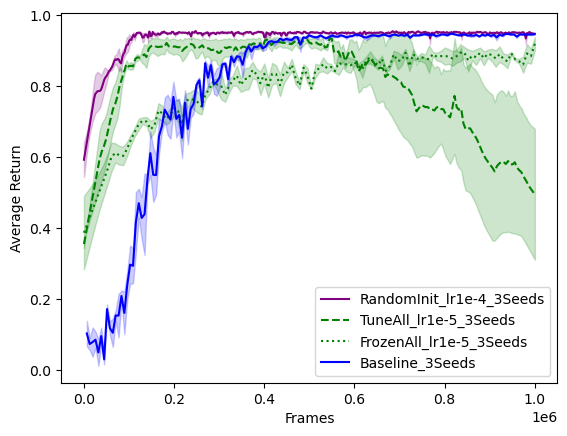

In [10]:
lang_comp_mode_and_lr_pairs = {
    "RandomInit": "1e-4",
    "TuneAll": "1e-5",
    "FrozenAll": "1e-5"
}
print(f"Ploting performances of the best lr of each language mode for  level {level}")
plot_best_perf_every_lang_mode_per_level(
        level,
        lang_comp_mode_and_lr_pairs,
        line_colors,
        line_styles,
        df_3lr_3lang_Disc,
        df_paper_levels,
        fig_dir,
        gh = None,
        num_samples=num_samples,
        debug=debug
)

In [11]:
level = "GoToBallNeighborOpenRoomR2"

df_3lr_3lang_GoTo = load_result_per_level(
        exp_result_dir,
        level,
        lr_list,
        short_lr_list,
        lang_comp_modes,
        history_type='full',
        )

total runs: 42
loaded runs: 27


Ploting training performance for RandomInit mode and level GoToBallNeighborOpenRoomR2
[RandomInit, LR(1e-4), Run 0] left: (27673, 0.3821533203124999), right: (998042, 0.8129638671874999), num_points: 88, seed:9632
[RandomInit, LR(1e-4), Extend] left: (0.0, 0.414632601200058), right: (1000000.0, 0.8263935369715301), num_points: 88
[RandomInit, LR(1e-4), Run 1] left: (25899, 0.4175781249999999), right: (992006, 0.815380859375), num_points: 91, seed:4070
[RandomInit, LR(1e-4), Extend] left: (0.0, 0.35226463155414806), right: (1000000.0, 0.8890550670720004), num_points: 91
[RandomInit, LR(1e-4), Run 2] left: (26599, 0.3976318359374999), right: (993073, 0.8297119140625), num_points: 82, seed:2606
[RandomInit, LR(1e-4), Extend] left: (0.0, 0.4815150827742173), right: (1000000.0, 0.8128299105188266), num_points: 82
[RandomInit, LR(1e-4)] max_n_nodes: 91, min_n_nodes: 82, mean_n_nodes: 87, std_n_nodes: 3.7416573867739413, num_samples: 82
[RandomInit, LR(3e-5), Run 0] left: (28794, 0.2216796875

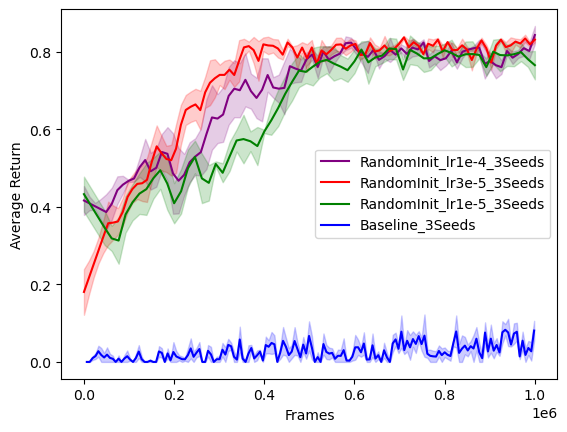

Ploting training performance for TuneAll mode and level GoToBallNeighborOpenRoomR2
[TuneAll, LR(1e-4), Run 0] left: (27181, 0.31064453125), right: (992514, 0.8281738281250001), num_points: 91, seed:1381
[TuneAll, LR(1e-4), Extend] left: (0.0, 0.2626540749399442), right: (1000000.0, 0.8640302338144794), num_points: 91
[TuneAll, LR(1e-4), Run 1] left: (31395, 0.2646728515625), right: (991313, 0.7455078125), num_points: 83, seed:2314
[TuneAll, LR(1e-4), Extend] left: (0.0, 0.20722835033871845), right: (1000000.0, 0.6997866691007034), num_points: 83
[TuneAll, LR(1e-4), Run 2] left: (28937, 0.3328125), right: (998385, 0.8508056640624999), num_points: 89, seed:6159
[TuneAll, LR(1e-4), Extend] left: (0.0, 0.25689368620143466), right: (1000000.0, 0.8697724344036104), num_points: 89
[TuneAll, LR(1e-4)] max_n_nodes: 91, min_n_nodes: 83, mean_n_nodes: 87, std_n_nodes: 3.39934634239519, num_samples: 83
[TuneAll, LR(3e-5), Run 0] left: (26993, 0.38369140625), right: (995129, 0.7223388671875), num_p

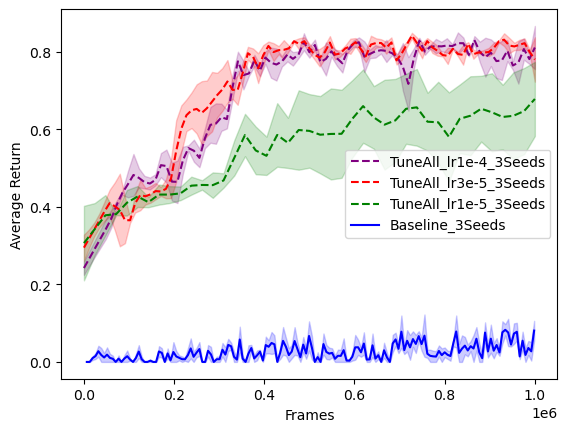

Ploting training performance for FrozenAll mode and level GoToBallNeighborOpenRoomR2
[FrozenAll, LR(1e-4), Run 0] left: (26823, 0.313623046875), right: (994686, 0.3568359375), num_points: 40, seed:838
[FrozenAll, LR(1e-4), Extend] left: (0.0, 0.2508947349096201), right: (1000000.0, 0.3370420124223241), num_points: 40
[FrozenAll, LR(1e-4), Run 1] left: (26617, 0.4600830078125), right: (990418, 0.3009765625), num_points: 39, seed:6800
[FrozenAll, LR(1e-4), Extend] left: (0.0, 0.5941167986885273), right: (1000000.0, 0.30213697492585845), num_points: 39
[FrozenAll, LR(1e-4), Run 2] left: (28449, 0.3347656249999999), right: (979006, 0.072314453125), num_points: 38, seed:8134
[FrozenAll, LR(1e-4), Extend] left: (0.0, 0.3219228976267686), right: (1000000.0, 0.03431549132331714), num_points: 38
[FrozenAll, LR(1e-4)] max_n_nodes: 40, min_n_nodes: 38, mean_n_nodes: 39, std_n_nodes: 0.816496580927726, num_samples: 38
[FrozenAll, LR(3e-5), Run 0] left: (27086, 0.285107421875), right: (1000122, 0.4

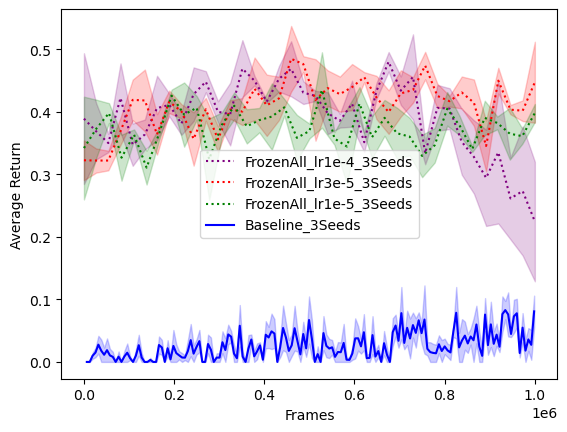

In [12]:
for lang_comp_mode in lang_comp_modes:
        print(f"Ploting training performance for {lang_comp_mode} mode and level {level}")
        gh=None
        plot_perf_per_lang_mode_per_level(
                level,
                lang_comp_mode,
                short_lr_list,
                line_colors,
                line_styles,
                df_3lr_3lang_GoTo,
                df_paper_levels,
                fig_dir,
                gh,
                num_samples=num_samples,
                debug=debug
        )

Ploting performances of the best lr of each language mode for  level GoToBallNeighborOpenRoomR2
[RandomInit, LR(3e-5), Run 0] left: (28794, 0.2216796875), right: (995491, 0.8279541015625), num_points: 94, seed:8268
[RandomInit, LR(3e-5), Extend] left: (0.0, 0.18664132604490435), right: (1000000.0, 0.8416783775450554), num_points: 94
[RandomInit, LR(3e-5), Run 1] left: (27128, 0.2603271484375), right: (1000101, 0.817578125), num_points: 97, seed:1106
[RandomInit, LR(3e-5), Extend] left: (0.0, 0.07534368045252224), right: (1000101, 0.817578125), num_points: 97
[RandomInit, LR(3e-5), Run 2] left: (27090, 0.3306396484375), right: (994898, 0.8314208984375), num_points: 95, seed:5945
[RandomInit, LR(3e-5), Extend] left: (0.0, 0.2791455790944344), right: (1000000.0, 0.8332764375788383), num_points: 95
[RandomInit, LR(3e-5)] max_n_nodes: 97, min_n_nodes: 94, mean_n_nodes: 95, std_n_nodes: 1.247219128924647, num_samples: 94
[TuneAll, LR(3e-5), Run 0] left: (26993, 0.38369140625), right: (995129

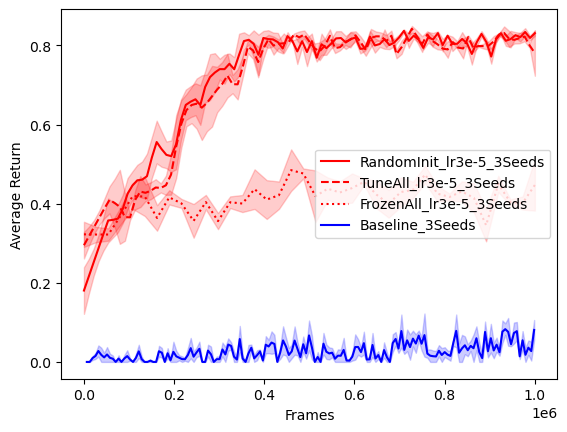

In [13]:
lang_comp_mode_and_lr_pairs = {
    "RandomInit": "3e-5",
    "TuneAll": "3e-5",
    "FrozenAll": "3e-5"
}
print(f"Ploting performances of the best lr of each language mode for  level {level}")
plot_best_perf_every_lang_mode_per_level(
        level,
        lang_comp_mode_and_lr_pairs,
        line_colors,
        line_styles,
        df_3lr_3lang_GoTo,
        df_paper_levels,
        fig_dir,
        gh = None,
        num_samples=num_samples,
        debug=debug
)

In [14]:
level = "MoveToNeighborClosedRoomR2"

df_3lr_3lang_Move = load_result_per_level(
        exp_result_dir,
        level,
        lr_list,
        short_lr_list,
        lang_comp_modes,
        history_type='full',
        )

total runs: 37
loaded runs: 27


Ploting training performance for RandomInit mode and level MoveToNeighborClosedRoomR2
[RandomInit, LR(1e-4), Run 0] left: (40016, 0.021142578125), right: (984658, 0.6027099609375), num_points: 39, seed:2619
[RandomInit, LR(1e-4), Extend] left: (0.0, 0.023319742706645157), right: (1000000.0, 0.6119841485528571), num_points: 39
[RandomInit, LR(1e-4), Run 1] left: (39635, 0.0577636718749999), right: (991280, 0.42421875), num_points: 32, seed:631
[RandomInit, LR(1e-4), Extend] left: (0.0, 0.08670544460740123), right: (1000000.0, 0.4108321967720715), num_points: 32
[RandomInit, LR(1e-4), Run 2] left: (39731, 0.0382080078125), right: (984522, 0.01806640625), num_points: 37, seed:5184
[RandomInit, LR(1e-4), Extend] left: (0.0, 0.06944909027118923), right: (1000000.0, -0.006103296002665046), num_points: 37
[RandomInit, LR(1e-4)] max_n_nodes: 39, min_n_nodes: 32, mean_n_nodes: 36, std_n_nodes: 2.943920288775949, num_samples: 32
[RandomInit, LR(3e-5), Run 0] left: (40230, 0.004443359375), right:

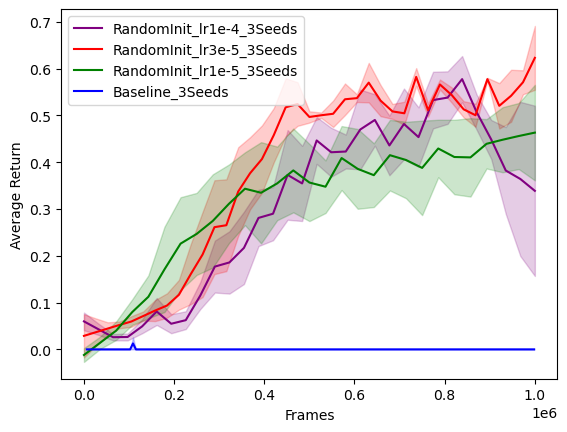

Ploting training performance for TuneAll mode and level MoveToNeighborClosedRoomR2
[TuneAll, LR(1e-4), Run 0] left: (40371, 0.011474609375), right: (996210, 0.388427734375), num_points: 45, seed:2360
[TuneAll, LR(1e-4), Extend] left: (0.0, -0.09382234516658121), right: (1000000.0, 0.41501741677072085), num_points: 45
[TuneAll, LR(1e-4), Run 1] left: (40221, 0.064794921875), right: (1001868, 0.187353515625), num_points: 55, seed:3433
[TuneAll, LR(1e-4), Extend] left: (0.0, 0.07807184264268785), right: (1001868, 0.187353515625), num_points: 55
[TuneAll, LR(1e-4), Run 2] left: (39734, 0.0055419921875), right: (973687, 0.0622070312499999), num_points: 51, seed:7524
[TuneAll, LR(1e-4), Extend] left: (0.0, 0.002046075381103383), right: (1000000.0, -0.21569485392788793), num_points: 51
[TuneAll, LR(1e-4)] max_n_nodes: 55, min_n_nodes: 45, mean_n_nodes: 50, std_n_nodes: 4.109609335312651, num_samples: 45
[TuneAll, LR(3e-5), Run 0] left: (40135, 0.0198242187499999), right: (985752, 0.4990722656

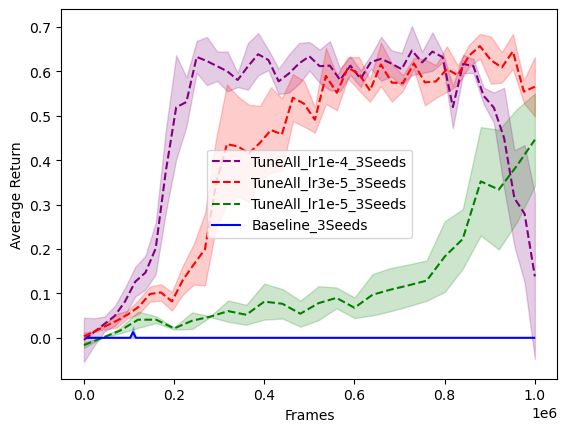

Ploting training performance for FrozenAll mode and level MoveToNeighborClosedRoomR2
[FrozenAll, LR(1e-4), Run 0] left: (40113, 0.0183349609375), right: (972601, 0.2342773437499999), num_points: 29, seed:9613
[FrozenAll, LR(1e-4), Extend] left: (0.0, 0.008960380121413565), right: (1000000.0, 0.17349854727361266), num_points: 29
[FrozenAll, LR(1e-4), Run 1] left: (39737, 0.0123535156249999), right: (980418, 0.2153808593749999), num_points: 29, seed:6419
[FrozenAll, LR(1e-4), Extend] left: (0.0, 0.0083140979000231), right: (1000000.0, 0.23043556535058873), num_points: 29
[FrozenAll, LR(1e-4), Run 2] left: (39904, 0.0227294921875), right: (993254, 0.2402099609375), num_points: 28, seed:6639
[FrozenAll, LR(1e-4), Extend] left: (0.0, -0.022805071943975408), right: (1000000.0, 0.22579955241335076), num_points: 28
[FrozenAll, LR(1e-4)] max_n_nodes: 29, min_n_nodes: 28, mean_n_nodes: 28, std_n_nodes: 0.4714045207910317, num_samples: 28
[FrozenAll, LR(3e-5), Run 0] left: (40327, 0.0046630859374

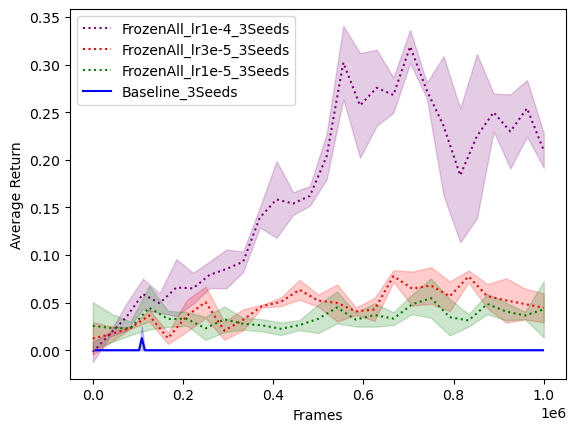

In [15]:
for lang_comp_mode in lang_comp_modes:
        print(f"Ploting training performance for {lang_comp_mode} mode and level {level}")
        gh=None
        plot_perf_per_lang_mode_per_level(
                level,
                lang_comp_mode,
                short_lr_list,
                line_colors,
                line_styles,
                df_3lr_3lang_Move,
                df_paper_levels,
                fig_dir,
                gh,
                num_samples=num_samples,
                debug=debug
        )

Ploting performances of the best lr of each language mode for  level MoveToNeighborClosedRoomR2
[RandomInit, LR(3e-5), Run 0] left: (40230, 0.004443359375), right: (997773, 0.6010498046874999), num_points: 42, seed:5532
[RandomInit, LR(3e-5), Extend] left: (0.0, -0.057336754853979474), right: (1000000.0, 0.6107875717125214), num_points: 42
[RandomInit, LR(3e-5), Run 1] left: (39945, 0.0768798828125), right: (986631, 0.68349609375), num_points: 42, seed:8723
[RandomInit, LR(3e-5), Extend] left: (0.0, 0.10072961954458026), right: (1000000.0, 0.747162398515068), num_points: 42
[RandomInit, LR(3e-5), Run 2] left: (40332, 0.0412353515624999), right: (997921, 0.5162109375), num_points: 39, seed:7368
[RandomInit, LR(3e-5), Extend] left: (0.0, 0.04329040553434344), right: (1000000.0, 0.5116848329665904), num_points: 39
[RandomInit, LR(3e-5)] max_n_nodes: 42, min_n_nodes: 39, mean_n_nodes: 41, std_n_nodes: 1.4142135623730951, num_samples: 39
[TuneAll, LR(3e-5), Run 0] left: (40135, 0.0198242187

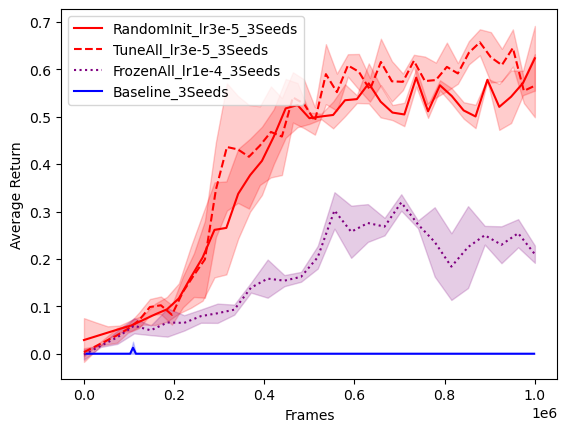

In [16]:
lang_comp_mode_and_lr_pairs = {
    "RandomInit": "3e-5",
    "TuneAll": "3e-5",
    "FrozenAll": "1e-4"
}
print(f"Ploting performances of the best lr of each language mode for  level {level}")
plot_best_perf_every_lang_mode_per_level(
        level,
        lang_comp_mode_and_lr_pairs,
        line_colors,
        line_styles,
        df_3lr_3lang_Move,
        df_paper_levels,
        fig_dir,
        gh = None,
        num_samples=num_samples,
        debug=debug
)

total runs: 43
loaded runs: 6
[RandomInit, LR(1e-4), Run 0] left: (17951, 0.6569091796875), right: (999055, 0.9483642578125), num_points: 401, seed:3805
[RandomInit, LR(1e-4, Extend)] left: (0.0, 0.622678721425357), right: (1000000.0, 0.9492733716547176), num_points: 401
[RandomInit, LR(1e-4), Run 1] left: (15067, 0.7518798828125), right: (998267, 0.946826171875), num_points: 402, seed:9600
[RandomInit, LR(1e-4, Extend)] left: (0.0, 0.6580863071152887), right: (1000000.0, 0.943844810243584), num_points: 402
[RandomInit, LR(1e-4), Run 2] left: (15145, 0.7208984375), right: (998079, 0.9490234375), num_points: 406, seed:6843
[RandomInit, LR(1e-4, Extend)] left: (0.0, 0.49749109588076446), right: (1000000.0, 0.9490234375), num_points: 406
[RandomInit, LR(1e-4)] max_n_nodes: 406, min_n_nodes: 401, mean_n_nodes: 403, std_n_nodes: 2.160246899469287, num_samples: 401
[TuneAll, LR(1e-5), Run 0] left: (23764, 0.48740234375), right: (976434, 0.2439208984374999), num_points: 213, seed:5094
[TuneAl

<Figure size 640x480 with 0 Axes>

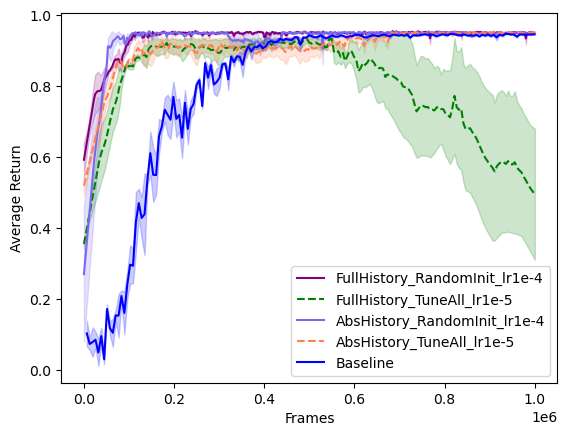

<Figure size 640x480 with 0 Axes>

In [17]:
level="DiscoverHiddenBallBlueBoxR2"
selected_configs = {
    "RandomInit": "1e-4",
    "TuneAll": "1e-5"
}
# lr_list = ["0.0001", "3e-05", "1e-05"]
selected_lr_list = ["0.0001", "1e-05"]

df_abs_Disc = load_abs_result_per_level(
        exp_result_dir,
        level,
        selected_lr_list,
        selected_configs,
        history_type='absR0',
        )
plot_full_vs_abs_selected_lang_mode_per_level(
        level,
        selected_configs,
        abs_line_colors,
        line_colors,
        line_styles,
        df_paper_levels,
        df_3lr_3lang_Disc,
        df_abs_Disc,
        fig_dir,
        gh = None,
        debug=debug,
        num_samples=num_samples,
        abs_marker=None
)

total runs: 42
loaded runs: 6
[RandomInit, LR(3e-5), Run 0] left: (28794, 0.2216796875), right: (995491, 0.8279541015625), num_points: 94, seed:8268
[RandomInit, LR(3e-5, Extend)] left: (0.0, 0.18664132604490435), right: (1000000.0, 0.8416783775450554), num_points: 94
[RandomInit, LR(3e-5), Run 1] left: (27128, 0.2603271484375), right: (1000101, 0.817578125), num_points: 97, seed:1106
[RandomInit, LR(3e-5, Extend)] left: (0.0, 0.07534368045252224), right: (1000101, 0.817578125), num_points: 97
[RandomInit, LR(3e-5), Run 2] left: (27090, 0.3306396484375), right: (994898, 0.8314208984375), num_points: 95, seed:5945
[RandomInit, LR(3e-5, Extend)] left: (0.0, 0.2791455790944344), right: (1000000.0, 0.8332764375788383), num_points: 95
[RandomInit, LR(3e-5)] max_n_nodes: 97, min_n_nodes: 94, mean_n_nodes: 95, std_n_nodes: 1.247219128924647, num_samples: 94
[TuneAll, LR(3e-5), Run 0] left: (26993, 0.38369140625), right: (995129, 0.7223388671875), num_points: 89, seed:5520
[TuneAll, LR(3e-5, E

<Figure size 640x480 with 0 Axes>

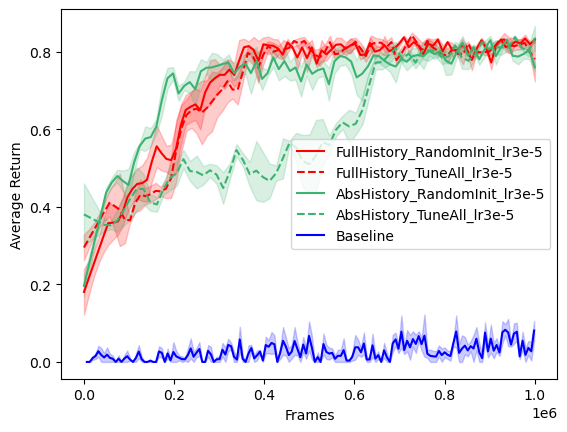

<Figure size 640x480 with 0 Axes>

In [18]:
level="GoToBallNeighborOpenRoomR2"
selected_configs = {
    "RandomInit": "3e-5",
    "TuneAll": "3e-5",
}
# lr_list = ["0.0001", "3e-05", "1e-05"]
selected_lr_list = ["3e-05", "3e-05"]

df_abs_GoTo = load_abs_result_per_level(
        exp_result_dir,
        level,
        selected_lr_list,
        selected_configs,
        history_type='absR0',
        )
plot_full_vs_abs_selected_lang_mode_per_level(
        level,
        selected_configs,
        abs_line_colors,
        line_colors,
        line_styles,
        df_paper_levels,
        df_3lr_3lang_GoTo,
        df_abs_GoTo,
        fig_dir,
        gh = None,
        debug=debug,
        num_samples=num_samples,
        abs_marker=None
)

total runs: 37
loaded runs: 6
[RandomInit, LR(3e-5), Run 0] left: (40230, 0.004443359375), right: (997773, 0.6010498046874999), num_points: 42, seed:5532
[RandomInit, LR(3e-5, Extend)] left: (0.0, -0.057336754853979474), right: (1000000.0, 0.6107875717125214), num_points: 42
[RandomInit, LR(3e-5), Run 1] left: (39945, 0.0768798828125), right: (986631, 0.68349609375), num_points: 42, seed:8723
[RandomInit, LR(3e-5, Extend)] left: (0.0, 0.10072961954458026), right: (1000000.0, 0.747162398515068), num_points: 42
[RandomInit, LR(3e-5), Run 2] left: (40332, 0.0412353515624999), right: (997921, 0.5162109375), num_points: 39, seed:7368
[RandomInit, LR(3e-5, Extend)] left: (0.0, 0.04329040553434344), right: (1000000.0, 0.5116848329665904), num_points: 39
[RandomInit, LR(3e-5)] max_n_nodes: 42, min_n_nodes: 39, mean_n_nodes: 41, std_n_nodes: 1.4142135623730951, num_samples: 39
[TuneAll, LR(3e-5), Run 0] left: (40135, 0.0198242187499999), right: (985752, 0.499072265625), num_points: 42, seed:586

<Figure size 640x480 with 0 Axes>

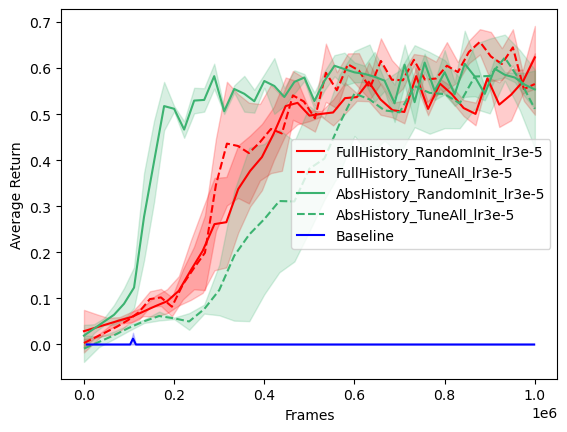

<Figure size 640x480 with 0 Axes>

In [19]:
level="MoveToNeighborClosedRoomR2"
selected_configs = {
    "RandomInit": "3e-5",
    "TuneAll": "3e-5",
}
# lr_list = ["0.0001", "3e-05", "1e-05"]
selected_lr_list = ["3e-05", "3e-05"]

df_abs_Move = load_abs_result_per_level(
        exp_result_dir,
        level,
        selected_lr_list,
        selected_configs,
        history_type='absR0',
        )
plot_full_vs_abs_selected_lang_mode_per_level(
        level,
        selected_configs,
        abs_line_colors,
        line_colors,
        line_styles,
        df_paper_levels,
        df_3lr_3lang_Move,
        df_abs_Move,
        fig_dir,
        gh = None,
        debug=debug,
        num_samples=num_samples,
        abs_marker=None
)